In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline  


/Users/chronowanderer/anaconda3/envs/tensorflow/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
TIME_STEPS = 8
HIDDEN_UNITS = 32
INPUT_UNITS = 2
OUTPUT_UNITS = 2
BATCH_SIZE = 4
TRAIN_SIZE = 400
EPOCH = 20


In [3]:
def atan_positive(x, y):
    if (x > 0) & (y > 0):
        theta = math.atan(y / x)
    elif (x == 0) & (y > 0):
        theta = math.pi / 2
    elif (x < 0):
        theta = math.pi + math.atan(y / x)
    elif (x == 0) & (y < 0):
        theta = 3 * math.pi / 2
    elif (x > 0) & (y <= 0):
        theta = 2 * math.pi + math.atan(y / x)
    return theta

def brwnm2(mu1, mu2, a, sigma, h, lentmax):
    locRT = 0
    theta_T = 999
    x = mu1 * h + sigma * numpy.random.randn(lentmax) * math.sqrt(h)
    y = mu2 * h + sigma * numpy.random.randn(lentmax) * math.sqrt(h)
    a_r = a - math.sqrt(h) * sigma / 2.0
    x_start = 0.0
    y_start = 0.0
    w = [x_start]
    z = [y_start] 
    flag = 0
    for k in numpy.arange(1, lentmax):
        w.append(w[k - 1] + x[k])
        z.append(z[k - 1] + y[k])
        if (flag == 0) & (w[k] ** 2 + z[k] ** 2 >= a_r ** 2):
            locRT = k
            theta_T = atan_positive(w[k], z[k]) / 2.0
            flag = 1
    return (w, z, theta_T, locRT)


In [ ]:
def semicircular_error(r, t):
    e = r - t
    if e >= 90:
        e = e - 180
    elif e < -90:
        e = e + 180
    return e


In [4]:
norm = 1.0
a = 1.0
sigma = 0.1
numSeries = 10
tmax = 2.0
h = 0.001
lentmax = int(tmax / h)
T = numpy.linspace(0, tmax, lentmax, endpoint = False)
DATA_i = 0
DATA_f = lentmax - 1
Target = []
Response = []
Error = []
RTloc = []
Data = []

RESP = 160
mu1 = norm * math.cos(2 * RESP * math.pi / 180)
mu2 = norm * math.sin(2 * RESP * math.pi / 180)

for i in numpy.arange(numSeries):
    (L_x, L_y, theta, t_loc) = brwnm2(mu1, mu2, a, sigma, h, lentmax)
    Target.append(RESP)
    Response.append(theta / math.pi * 180)
    Error.append(semicircular_error(Response[i], RESP))
    RTloc.append(t_loc)
    temp = []
    for j in numpy.arange(lentmax):
        temp.append([L_x[j], L_y[j]])
    Data.append(temp)


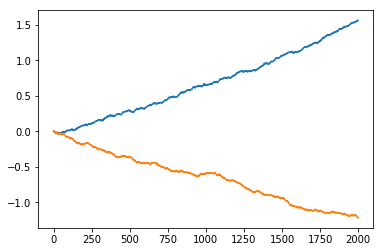

In [5]:
SERIES = 1
FINALE_TIME = RTloc[SERIES - 1]
TRAIN_SIZE = int(FINALE_TIME * 0.25)

dataset = Data[SERIES]
plt.plot(dataset)
plt.show()


In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i : (i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)


In [7]:
look_back = TIME_STEPS

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = TRAIN_SIZE
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size-look_back:len(dataset),:]

# use this function to prepare the train and test datasets for modeling
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[2]))
testX = numpy.reshape(testX, (testX.shape[0], look_back, testX.shape[2]))


In [8]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(HIDDEN_UNITS, input_shape=(look_back, INPUT_UNITS)))
model.add(Dense(OUTPUT_UNITS))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs = EPOCH, batch_size = BATCH_SIZE, verbose = 2)


Epoch 1/20
 - 1s - loss: 0.0741
Epoch 2/20
 - 0s - loss: 7.2549e-04
Epoch 3/20
 - 0s - loss: 4.1324e-04
Epoch 4/20
 - 0s - loss: 3.3605e-04
Epoch 5/20
 - 0s - loss: 2.7499e-04
Epoch 6/20
 - 0s - loss: 2.0717e-04
Epoch 7/20
 - 0s - loss: 1.6020e-04
Epoch 8/20
 - 0s - loss: 1.0369e-04
Epoch 9/20
 - 0s - loss: 7.0214e-05
Epoch 10/20
 - 0s - loss: 5.0718e-05
Epoch 11/20
 - 0s - loss: 3.9474e-05
Epoch 12/20
 - 0s - loss: 3.1543e-05
Epoch 13/20
 - 0s - loss: 2.8159e-05
Epoch 14/20
 - 0s - loss: 2.9240e-05
Epoch 15/20
 - 0s - loss: 3.0925e-05
Epoch 16/20
 - 0s - loss: 3.0394e-05
Epoch 17/20
 - 0s - loss: 2.8886e-05
Epoch 18/20
 - 0s - loss: 2.7983e-05
Epoch 19/20
 - 0s - loss: 3.1961e-05
Epoch 20/20
 - 0s - loss: 2.6412e-05


In [9]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.4f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.4f RMSE' % (testScore))


Train Score: 0.0070 RMSE
Test Score: 0.2488 RMSE


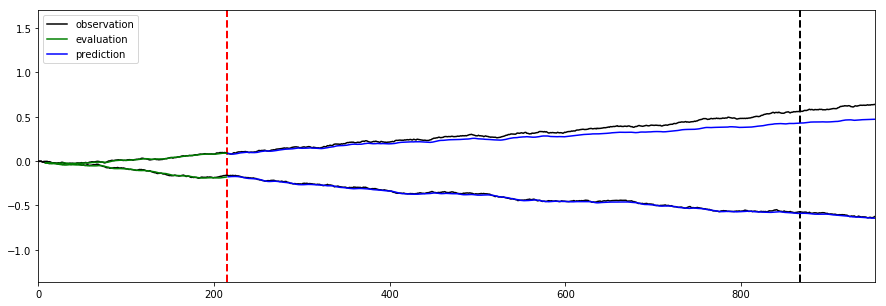

In [10]:
plt.figure(figsize=(15, 5))
plt.xlim(DATA_i, int(FINALE_TIME * 1.1))
plt.axvline(train_size - 1, linestyle="dashed", linewidth = 2, color='r')
plt.axvline(FINALE_TIME, linestyle="dashed", linewidth = 2, color='k')

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
observed_lines = plt.plot(scaler.inverse_transform(dataset), label="observation", color="k")
evaluated_lines = plt.plot(trainPredictPlot, label="evaluation", color="g")
predicted_lines = plt.plot(testPredictPlot, label="prediction", color="b")
plt.legend(handles=[observed_lines[0], evaluated_lines[0], predicted_lines[0]],loc="upper left")
plt.show()


In [11]:
# Output the estimated response
a_r = a - math.sqrt(h) * sigma / 2.0
for k in numpy.arange(lentmax):
    if (trainPredictPlot[k,1] ** 2 + trainPredictPlot[k,0] ** 2 >= a_r ** 2):
        Estimated_locRT = k
        temp = trainPredictPlot[k,:]
        Estimated_theta = atan_positive(temp[0], temp[1]) / 2.0
        break
    elif (testPredictPlot[k,1] ** 2 + testPredictPlot[k,0] ** 2 >= a_r ** 2):
        Estimated_locRT = k
        temp = testPredictPlot[k,:]
        Estimated_theta = atan_positive(temp[0], temp[1]) / 2.0
        break
Estimated_theta = Estimated_theta / math.pi * 180

print('Estimated Response: %.4f degs' % (Estimated_theta))
print('Estimated Reaction Time: %d ms' % (int(Estimated_locRT * h * 1000)))
print('Drift Direction: %.4f degs' % (RESP))
print('Mean Reaction Time: %d ms' % (int(FINALE_TIME * h * 1000)))


Estimated Response: 152.5075 degs
Estimated Reaction Time: 1311 ms
Drift Direction: 160.0000 degs
Mean Reaction Time: 867 ms


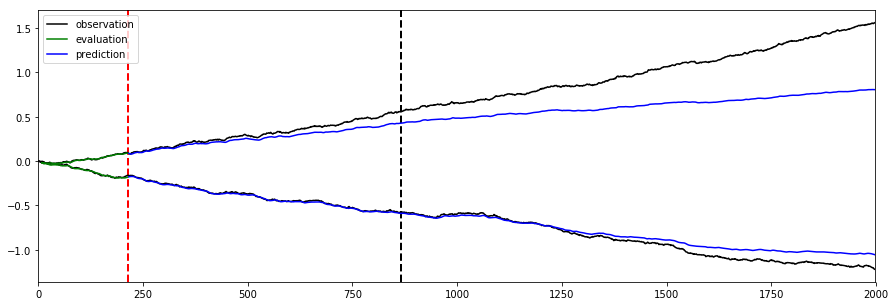

In [12]:
plt.figure(figsize=(15, 5))
plt.xlim(DATA_i, DATA_f)
plt.axvline(train_size - 1, linestyle="dashed", linewidth = 2, color='r')
plt.axvline(FINALE_TIME, linestyle="dashed", linewidth = 2, color='k')

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
observed_lines = plt.plot(scaler.inverse_transform(dataset), label="observation", color="k")
evaluated_lines = plt.plot(trainPredictPlot, label="evaluation", color="g")
predicted_lines = plt.plot(testPredictPlot, label="prediction", color="b")
plt.legend(handles=[observed_lines[0], evaluated_lines[0], predicted_lines[0]],loc="upper left")
plt.show()
